In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 使用 Cifar10 訓練 DNN 分類模型 
Cifar 10 中包含五萬張訓練資料與一萬張測試資料 

每一張資料皆為包含 RGB 三個頻道的彩色圖片，解析度為 32*32

這裡我嘗試兩種方法

- 直接將三個頻道展開為 32 * 32 * 3 的向量進行訓練
- 將 RGB 彩色圖片(三個頻道)轉為灰階圖片(一個頻道)，再展開成 32 * 32 的向量進行訓練

## 方法一：直接將三個頻道展開為 32 * 32 * 3 的向量進行訓練

### 1.資料整理

In [ ]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical

(X, y), (x_test, y_test) = cifar10.load_data()  #讀取資料

X = X.reshape((50000, 32*32*3))  #將訓練資料展開為 32 * 32 * 3 的向量
X = X.astype('float32') / 255.  #做 Normalization
x_test = x_test.reshape((10000, 32*32*3))  #將測試資料展開為 32 * 32 * 3 的向量
x_test = x_test.astype('float32') / 255.  #做 Normalization

y = to_categorical(y) #將訓練標籤做 one-hot encoding
y_test = to_categorical(y_test) #將測試標籤做 one-hot encoding

print("Check the shape of data")  #印出資料維度資訊確認
print('\n',
      "shape of x_train:\t", X.shape, '\n', 
      "shape of y_train:\t", y.shape, '\n',
      "shape of x_test:\t", x_test.shape, '\n',
      "shape of y_test:\t", y_test.shape)

Check the shape of data

 shape of x_train:	 (50000, 3072) 
 shape of y_train:	 (50000, 10) 
 shape of x_test:	 (10000, 3072) 
 shape of y_test:	 (10000, 10)


### 2.建立並訓練模型

In [ ]:
from keras import models
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend as K
K.clear_session()  #清除先前建立的模型
network = models.Sequential()
network.add(Dense(128, activation = 'relu', input_shape = (32*32*3, )))
network.add(Dense(256, activation = 'relu'))
network.add(Dense(512, activation = 'relu'))
network.add(Dense(1024, activation = 'relu'))
network.add(Dense(512, activation = 'relu'))
network.add(Dense(256, activation = 'relu'))
network.add(Dense(128, activation = 'relu'))
network.add(Dense(10, activation = 'softmax'))

earlystop = EarlyStopping(monitor="val_loss", patience = 10, verbose = 1) #設定earlystop，監控驗證誤差，當驗證誤差沒有持續下降時，可提前停止訓練，以節省時間並避免過擬合
network.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
print(network.summary())

history = network.fit(X, y,
                      epochs=100, batch_size=128,
                      validation_split=0.2, #切分20%的資料作為驗證資料
                      callbacks=[earlystop],  #將上面設定的 earlystop 應用進來
                      shuffle=True,
                      verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3

### 3.畫出訓練過程訓練資料與驗證資料的準確度與 loss

用來了解模式是否有過擬合的情形

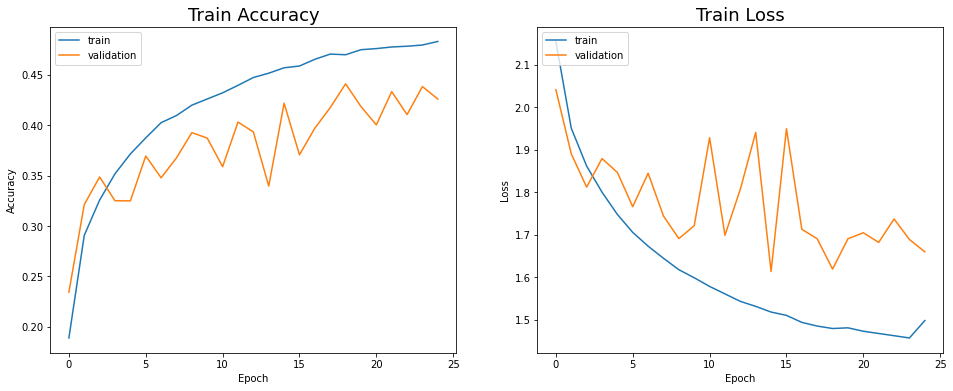

In [ ]:
def show_train_history(train_history): #定義一函數用來畫出訓練過程訓練資料與驗證資料的準確度與 loss
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    plt.plot(train_history.history["accuracy"])
    plt.plot(train_history.history["val_accuracy"])
    plt.title("Train Accuracy", fontsize=18)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.subplot(122)
    plt.plot(train_history.history["loss"])
    plt.plot(train_history.history["val_loss"])
    plt.title("Train Loss", fontsize=18)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
import matplotlib.pyplot as plt
show_train_history(history)

### 4.顯示模型在訓練資料與測試資料中的準確度

In [ ]:
scores_train = network.evaluate(X, y) #將模型帶入訓練資料，並取得準確度
scores_test = network.evaluate(x_test, y_test)  #將模型帶入測試資料，並取得準確度

print(f"Accuracy of Training Data= {scores_train[1]:.2f}") 
print(f"Accuracy of Testing Data= {scores_test[1]:.2f}") 

313/313 [==============================] - 1s 3ms/step - loss: 1.6264 - accuracy: 0.4317
Accuracy of Training Data= 0.46
Accuracy of Testing Data= 0.43


### 5.顯示訓練資料以及測試資料之 Confusion Matrix
用於了解訓練出來的模型在哪些地方容易分類錯誤

In [ ]:
import pandas as pd
import numpy as np
prediction_train = np.argmax(network.predict(X), axis=-1)
prediction_test = np.argmax(network.predict(x_test), axis=-1)
(_, y), (_, y_test) = cifar10.load_data()

print('Labels:\n\t0:airplain\t1:automobile\t2:bird\t3:cat\t4:deer\t5:dog\t6:frog\t7:horse\t8:ship\t9:truck\n')
print('Confusion Matrix of Training Data')
pd.crosstab(y.reshape(-1), prediction_train, rownames=['label'],colnames=['predict'])
print('\n')
print('Confusion Matrix of Testing Data')
pd.crosstab(y_test.reshape(-1), prediction_test, rownames=['label'],colnames=['predict'])

Labels:
	0:airplain	1:automobile	2:bird	3:cat	4:deer	5:dog	6:frog	7:horse	8:ship	9:truck

Confusion Matrix of Training Data


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,1186,386,887,240,115,213,263,117,1086,507
1,35,3406,74,153,39,93,120,65,308,707
2,86,162,2111,444,345,379,1045,134,162,132
3,16,188,395,1716,83,1051,1156,81,115,199
4,63,138,997,427,1384,270,1262,118,147,194
5,14,138,473,962,97,2091,901,114,82,128
6,7,107,349,411,165,271,3506,28,38,118
7,23,133,585,499,481,401,650,1728,106,394
8,94,424,136,224,29,231,82,17,3329,434




Confusion Matrix of Testing Data


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,219,67,204,53,24,40,52,18,238,85
1,3,654,24,35,3,27,29,20,72,133
2,26,31,382,98,59,80,230,38,35,21
3,1,26,86,316,17,233,230,18,29,44
4,19,32,229,90,221,60,262,29,29,29
5,3,18,88,205,15,377,198,37,25,34
6,1,26,79,67,34,65,686,5,13,24
7,11,30,109,111,94,87,132,320,15,91
8,22,93,27,59,11,45,17,3,638,85


## 方法二：將 RGB 彩色圖片(三個頻道)轉為灰階圖片(一個頻道)，再展開成 32 * 32 的向量進行訓練


### 1.將 RGB 圖片轉換為 灰階圖片

灰階圖片 = (0.3 * R) + (0.59 * G) + (0.11 * B)

[轉換方法參考資料](https://www.tutorialspoint.com/dip/grayscale_to_rgb_conversion.htm)

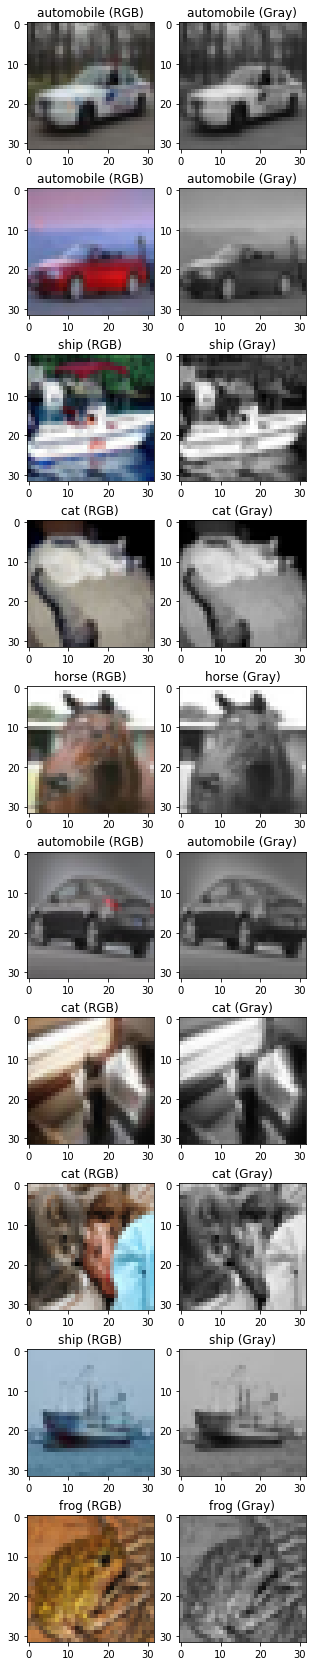

In [ ]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

(X, y), (x_test, y_test) = cifar10.load_data()  #讀入資料
gray_X = X[:,:,:,0] * 0.3 + X[:,:,:,1] * 0.59 + X[:,:,:,2] * 0.11 #將訓練資料轉為灰階
x_test = x_test[:,:,:,0] * 0.3 + x_test[:,:,:,1] * 0.59 + x_test[:,:,:,2] * 0.11  #將測試資料轉為灰階
label = {"0":"airplain",
         "1":"automobile",
         "2":"bird",
         "3":"cat",
         "4":"deer",
         "5":"dog",
         "6":"frog",
         "7":"horse",
         "8":"ship",
         "9":"truck"}  #圖片的標籤

#檢查轉為灰階圖片後是否正確
pics = [random.randint(1,50000) for _ in range(10)] #隨機選出 10 個 50000 以內的整數，用來隨機選取 X 內的圖
f, axes = plt.subplots(10,2,figsize=(5,30)) #將原圖與轉換後的灰階圖片左右比較
for i, pic in enumerate(pics):
    color = axes[i, 0].imshow(X[pic])  #顯示彩色圖片
    color_title = axes[i,0].set_title(f'{label[str(y.reshape(-1)[pic])]} (RGB)')  #設定彩色圖片之標題
    gray = axes[i, 1].imshow(gray_X[pic], cmap='gray', vmin=0, vmax=255)  #顯示灰階圖片
    gray_title = axes[i,1].set_title(f'{label[str(y.reshape(-1)[pic])]} (Gray)')  #設定灰階圖片之標題

### 2.資料整理

In [ ]:
gray_X = gray_X.reshape((50000, 32*32))  #將訓練資料轉換為 32 * 32 之向量
gray_X = gray_X.astype('float32') / 255.  #做 Normalization
x_test = x_test.reshape((10000, 32*32))  #將測試資料轉換為 32 * 32 之向量
x_test = x_test.astype('float32') / 255.  #做 Normalization

y = to_categorical(y) #將訓練資料標籤做 one-hot encoding
y_test = to_categorical(y_test)  #將測試資料標籤做 one-hot encoding

print("Check the shape of data") #確認轉換後的資料維度資訊
print('\n',
      "shape of x_train:\t", gray_X.shape, '\n', 
      "shape of y_train:\t", y.shape, '\n',
      "shape of x_test:\t", x_test.shape, '\n',
      "shape of y_test:\t", y_test.shape)

Check the shape of data

 shape of x_train:	 (50000, 1024) 
 shape of y_train:	 (50000, 10) 
 shape of x_test:	 (10000, 1024) 
 shape of y_test:	 (10000, 10)


### 3.建立並訓練模型

In [ ]:
from keras import models
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend as K
K.clear_session()
network = models.Sequential()
network.add(Dense(128, activation = 'relu', input_shape = (32*32, )))
network.add(Dense(256, activation = 'relu'))
network.add(Dense(512, activation = 'relu'))
network.add(Dense(1024, activation = 'relu'))
network.add(Dense(512, activation = 'relu'))
network.add(Dense(256, activation = 'relu'))
network.add(Dense(128, activation = 'relu'))
network.add(Dense(10, activation = 'softmax'))

earlystop = EarlyStopping(monitor="val_loss", patience = 10, verbose = 1)
network.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
print(network.summary())

history = network.fit(gray_X, y, 
                      epochs=100, batch_size=256, 
                      validation_split=0.2,
                      callbacks=[earlystop],
                      shuffle=True,
                      verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3

### 4.畫出訓練過程訓練資料與驗證資料的準確度與 loss

用來了解模式是否有過擬合的情形

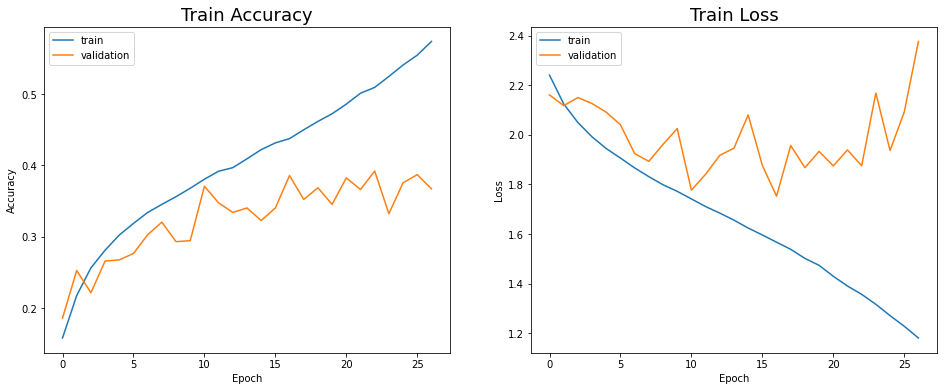

In [ ]:
import matplotlib.pyplot as plt
show_train_history(history)

### 5.顯示模型在訓練資料與測試資料中的準確度

In [ ]:
scores_train = network.evaluate(gray_X, y)
scores_test = network.evaluate(x_test, y_test)

print(f"Accuracy of Training Data= {scores_train[1]:.2f}") 
print(f"Accuracy of Testing Data= {scores_test[1]:.2f}") 

313/313 [==============================] - 1s 2ms/step - loss: 2.3622 - accuracy: 0.3735
Accuracy of Training Data= 0.49
Accuracy of Testing Data= 0.37


### 6.顯示訓練資料以及測試資料之 Confusion Matrix
用於了解訓練出來的模型在哪些地方容易分類錯誤

In [ ]:
import pandas as pd
prediction_train = np.argmax(network.predict(gray_X), axis=-1)
prediction_test = np.argmax(network.predict(x_test), axis=-1)
(_, y), (_, y_test) = cifar10.load_data()

print('Labels:\n\t0:airplain\t1:automobile\t2:bird\t3:cat\t4:deer\t5:dog\t6:frog\t7:horse\t8:ship\t9:truck\n')
print('Confusion Matrix of Training Data')
pd.crosstab(y.reshape(-1), prediction_train, rownames=['label'],colnames=['predict'])
print('\n')
print('Confusion Matrix of Testing Data')
pd.crosstab(y_test.reshape(-1), prediction_test, rownames=['label'],colnames=['predict'])

Labels:
	0:airplain	1:automobile	2:bird	3:cat	4:deer	5:dog	6:frog	7:horse	8:ship	9:truck

Confusion Matrix of Training Data


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,2651,217,457,36,469,69,94,124,736,147
1,338,3584,22,22,101,50,26,45,328,484
2,484,198,1726,173,1242,362,219,166,288,142
3,388,424,247,1413,619,741,264,193,341,370
4,539,254,390,96,2728,187,143,256,298,109
5,375,299,256,291,542,2230,185,266,328,228
6,427,649,199,170,893,300,1668,164,308,222
7,455,263,212,122,650,279,85,2452,214,268
8,711,445,61,46,272,54,37,25,3182,167




Confusion Matrix of Testing Data


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,435,60,127,8,118,16,14,31,155,36
1,76,591,11,12,29,17,9,11,93,151
2,100,56,265,43,256,79,56,38,73,34
3,81,90,75,157,136,167,78,54,72,90
4,113,62,89,21,430,71,42,70,74,28
5,88,74,67,100,132,311,47,60,75,46
6,121,150,49,42,190,82,215,32,60,59
7,111,64,49,30,141,72,25,376,53,79
8,173,103,19,5,72,21,5,16,542,44


## 結論
在想像中，會認為直接把 RGB 三個頻道直接展開成向量會造成同一個像素點分成三個特徵感覺比較不合理，但將 RGB 圖片轉換為灰階圖片後，模型可學習的特徵其實是減少的，由結果來看，方法一與方法二在訓練資料中結果差不多，但在測試資料中方法一的準確度較方法二來得高，代表深度神經網路在較多的特徵下依然是有辦法分辨並學習。